In [1]:
# %matplotlib notebook
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
from scipy.interpolate import UnivariateSpline
import pandas as pd
import numpy as np

In [35]:
class ZTF_fake_LC(object):
    def __init__(self, object_name, ZTF_cad_name, input_folder='../data/fakes/input'):
        self.object_name = object_name
        self.ZTF_cad_name = ZTF_cad_name
        if not(object_name.startswith('flat')):
            self.data = pd.read_csv(input_folder+'/LC-input/'+self.object_name+'.csv')
            self.time = self.data['mjd']
            self.mag = self.data['mag']
#             self.magerr = self.data['magerr']
        self.cad_file = pd.read_csv(input_folder+'/ZTF_cadence/'+self.ZTF_cad_name+'.csv')
        self.time_field = self.cad_file['mjd']



        
    def generate_fake_LC(self, smoth_factor=0.1, shift=0., k=3):
        self.shift = shift
        delta_t = self.time_field[0] - self.time[0] + self.shift
        self.time_new = self.time + delta_t 
        self.spl = UnivariateSpline(self.time_new, self.mag, k=k)
        self.time_int = np.linspace(self.time_new.min(axis=0), self.time_new.max(axis=0), num=1000, endpoint=True)
        self.smoth_factor = smoth_factor
        self.spl.set_smoothing_factor(self.smoth_factor)
        if np.min(self.time_field)> np.min(self.time_new) and  np.max(self.time_field)< np.max(self.time_new):
            self.complete_cadence = True
        else :
            self.complete_cadence = False
            Filtre = np.ones(len(self.time_field), dtype = bool)
            for i, t  in enumerate(self.time_field):
                if t < np.min(self.time_new) or t > np.max(self.time_new):
                    Filtre[i] = False
            self.time_field = self.time_field[Filtre]
        print(self.complete_cadence)  
        self.mag_out = self.spl(self.time_field) 
        self.magerr_out = 0.0297 * self.mag_out - 0.4179
    
    def generate_flat_fake_LC(self, mag_input=14. ,noise=0.2):
        self.smoth_factor = None
        self.shift = None
        self.complete_cadence = True
        self.mag_out = np.random.normal(loc=mag_input, scale=noise, size=len(self.time_field))
        self.magerr_out = 0.0297 * self.mag_out - 0.4179

    def visualise_intet_fit(self): 
        plt.plot(self.time_int, self.spl(self.time_int), 'b', lw=2, label='UniSpl') # interpolation
        plt.errorbar(self.time_new, self.mag,  linestyle='',
                     color='orange', marker='.', label='data_in')
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out,
                     linestyle='', marker='.',color='black', label='data_out')
        plt.gca().invert_yaxis()
        plt.legend(loc='best')
        plt.show()
        plt.close()
        
        
    def plot_fake_LC(self, figsize=(6,5), output_folder='../figs/fakes/'):
        fig = plt.figure(figsize=figsize)
        plt.errorbar(self.time_field, self.mag_out, yerr=self.magerr_out, 
                     linestyle='', marker='.',color='black', 
                     label= 'smoth factor = '+str(self.smoth_factor)+'\nshift = '+str(self.shift))
        plt.xlabel('mjd', fontsize=10)
        plt.ylabel('mag', fontsize=10)
        plt.gca().invert_yaxis()
        plt.legend()
        plt.savefig(output_folder+self.ZTF_cad_name +'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.png')   
        plt.show()
        plt.close()
        
    def write_output(self, output_folder='../data/fakes/output/'):
        d = {'mjd': self.time_field, 'mag': self.mag_out, 'magerr': self.magerr_out, 'clrcoeff': None}
        df = pd.DataFrame(data=d)
        df.to_csv(output_folder+ self.ZTF_cad_name+'/'+self.object_name+'_'+str(self.smoth_factor)+'_'+str(self.shift)+'_'+str(self.complete_cadence)+'.csv')          
        


# Generate fake LC from files

False


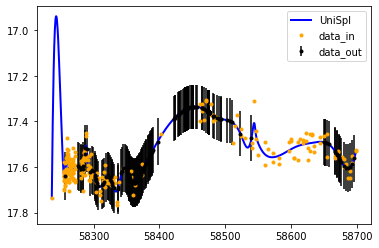

In [37]:
ztf_fake = ZTF_fake_LC('ZTF18aasszwr_format_r', 'FID807')
ztf_fake.generate_fake_LC(smoth_factor=0.3, shift=-20)
ztf_fake.visualise_intet_fit()


# Save figures and output file

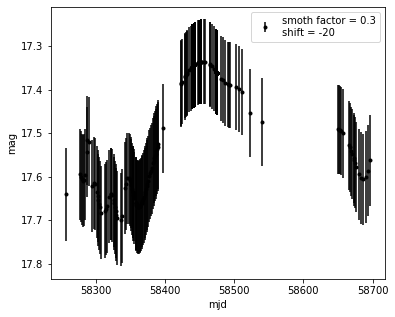

In [4]:
ztf_fake.plot_fake_LC()
ztf_fake.write_output()

# Generate fake Flat LC

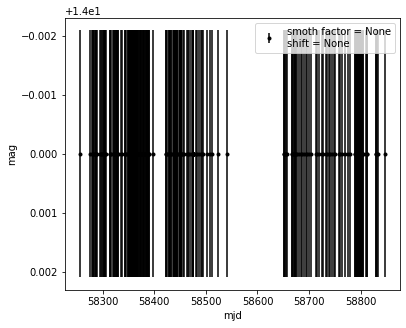

In [44]:
ztf_fake = ZTF_fake_LC('flat', 'FID807')
ztf_fake.generate_flat_fake_LC(mag_input=14. ,noise=0.0)
ztf_fake.plot_fake_LC()
ztf_fake.write_output()